# TACO (Garbage) Detection (SSD MobileNet v2) with TensorFlow

# THIS NOTEBOOK IS FOR REFERENCE ONLY. DO NOT EXECUTE.

TACO can be found here: http://tacodataset.org/. 🌮 is an open image dataset of waste in the wild. It contains photos of litter taken under diverse environments, from tropical beaches to London streets.

We are going to use pretrained models in this notebook to show how you can do inference on them of unseen images. The pretrained models can be found here: https://www.kaggle.com/bouweceunen/trained-models-taco-trash-annotations-in-context

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import json
import os

In [2]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 49445 (delta 5), reused 12 (delta 0), pack-reused 49428
Receiving objects: 100% (49445/49445), 558.65 MiB | 35.93 MiB/s, done.
Resolving deltas: 100% (34083/34083), done.
Checking out files: 100% (2196/2196), done.


In [3]:
# install object_detection library
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

Processing /kaggle/working/models/research
     |████████████████████████████████| 8.9 MB 8.2 MB/s 
     |████████████████████████████████| 89 kB 4.3 MB/s 
     |████████████████████████████████| 151 kB 20.3 MB/s 
     |████████████████████████████████| 2.0 MB 16.0 MB/s 
     |████████████████████████████████| 41 kB 48 kB/s 
     |████████████████████████████████| 56 kB 3.0 MB/s 
     |████████████████████████████████| 61 kB 4.7 MB/s 
     |████████████████████████████████| 840 kB 18.5 MB/s 
     |████████████████████████████████| 46 kB 3.0 MB/s 
     |████████████████████████████████| 95 kB 3.7 MB/s 
     |████████████████████████████████| 172 kB 15.4 MB/s 
     |████████████████████████████████| 352 kB 19.3 MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1605877 sha256=98b4036e31303a034e0812eb6f6bc6aaf17338e29dc73ed6d6fae10f3d819b0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-nf8rv8j7/wheels/d3/e0/37/addaa349be05bc9a8e02e02876c315

In [4]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [5]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [6]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

# Create LabelMap

First we need to create the label map.

In [7]:
DATA_DIR = '/kaggle/input/tacotrashdataset/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60

In [8]:
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)
    
categories = data['categories']

In [9]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [10]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Reconstruct Frozen Graph

Now we are going to reconstruct the TensorFlow frozen graph (.pb).

In [11]:
detection_graph = reconstruct("../input/trained-models-taco-trash-annotations-in-context/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


# Validate Test Images

We can now test it on some test images.

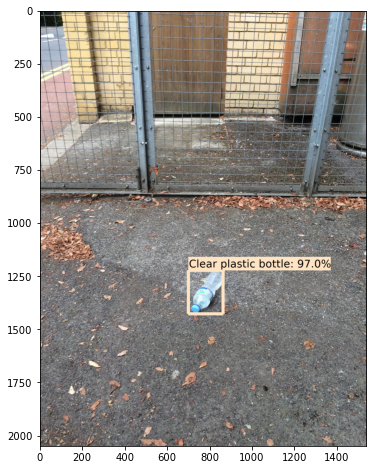

In [12]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000000.jpg')

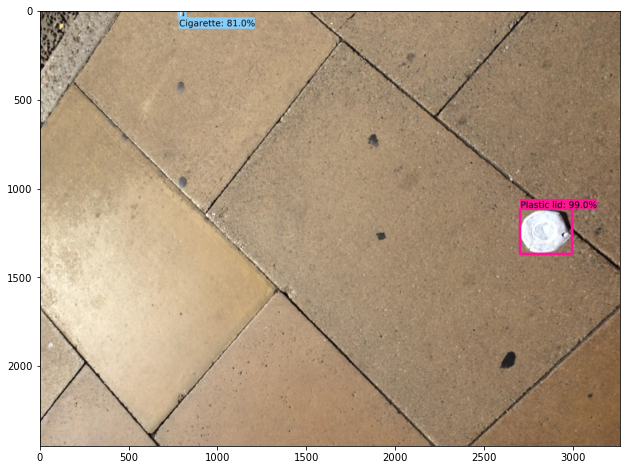

In [13]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_3/IMG_4852.JPG')

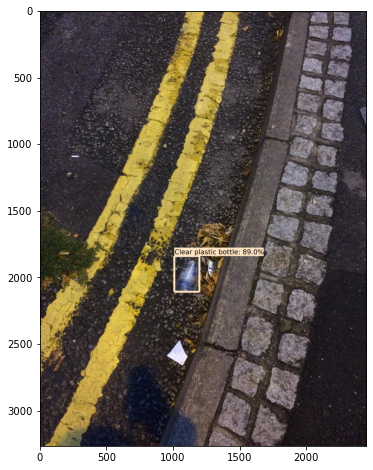

In [14]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_5/000000.JPG')

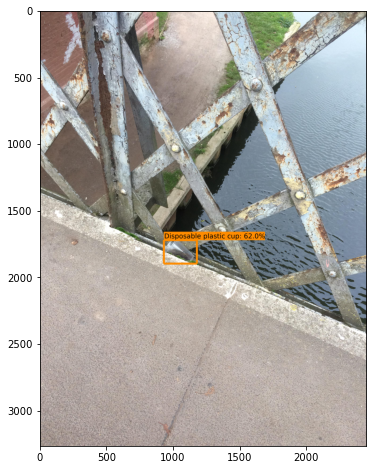

In [15]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_6/000000.JPG')

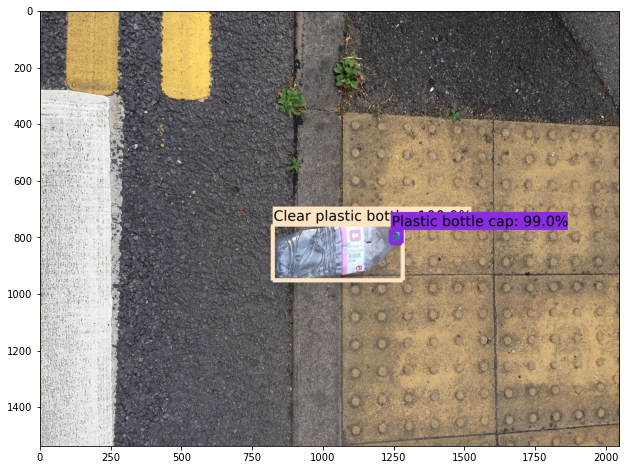

In [16]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000001.jpg')

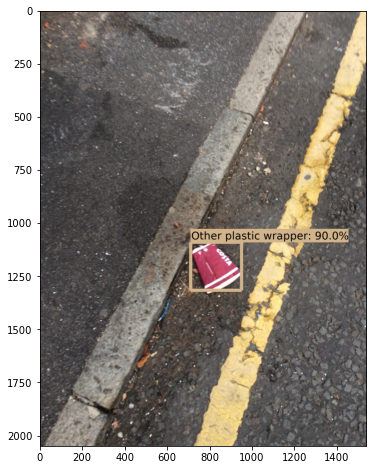

In [17]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000003.jpg')

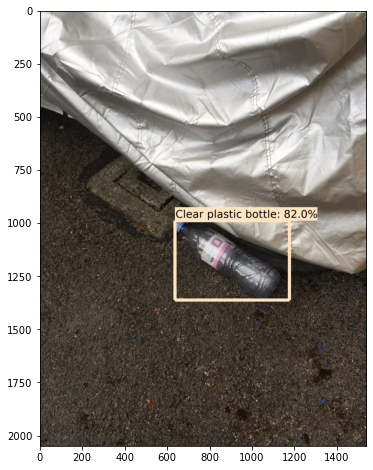

In [18]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000010.jpg')

# Cleanup

In [19]:
! rm -rf ./models